<center><p float="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/e/e9/4_RGB_McCombs_School_Brand_Branded.png" width="300" height="100"/>
  <img src="https://mma.prnewswire.com/media/1458111/Great_Learning_Logo.jpg?p=facebook" width="200" height="100"/>
</p></center>

<h1><center><font size=8>Artificial Intelligence and Machine Learning</center></font></h1>
<h1><center>Unsupervised Learning: AllLife Bank Customer Segmentation</center></h1>
<h4><center>Author: Enrique Martin Sanchez</center></h4>

# Description

## Context

AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help

 
## Objective
To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.

 
## Data Description
The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).

#Data Dictionary
- Sl_No: Primary key of the records
- Customer Key: Customer identification number
- Average Credit Limit: Average credit limit of each customer for all credit cards
- Total credit cards: Total number of credit cards possessed by the customer
- Total visits bank: Total number of visits that customer made (yearly) personally to the bank
- Total visits online: Total number of visits or online logins made by the customer (yearly)
- Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist, pdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

%matplotlib inline

pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.options.display.float_format = '{:,.4f}'.format

import warnings
warnings.filterwarnings('ignore')

# Support Functions

In [2]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [3]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = "{:,.0f}".format(
                p.get_height()
              )  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

# EDA - Exploratory data anlyisis

## Understanding the data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
data = pd.read_excel('/content/drive/MyDrive/Data Science/Courses/AIML University of Texas/6. Unsupervised Learning/Project 6: Unsupervised Learning: AllLife Bank Customer Segmentation/Credit Card Customer Data.xlsx')
df = data.copy()

In [6]:
df.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [7]:
df.shape

(660, 7)

**Insights**
- There are 7 columns
- There are 660 rows of data

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


**Insights**
- All the columns are numeric
- There are no missing data

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Sl_No,660.0000,330.5000,190.6699,1.0000,165.7500,330.5000,495.2500,660.0000
Customer Key,660.0000,"55,141.4439","25,627.7722","11,265.0000","33,825.2500","53,874.5000","77,202.5000","99,843.0000"
Avg_Credit_Limit,660.0000,"34,574.2424","37,625.4878","3,000.0000","10,000.0000","18,000.0000","48,000.0000","200,000.0000"
Total_Credit_Cards,660.0000,4.7061,2.1678,1.0000,3.0000,5.0000,6.0000,10.0000
Total_visits_bank,660.0000,2.4030,1.6318,0.0000,1.0000,2.0000,4.0000,5.0000
Total_visits_online,660.0000,2.6061,2.9357,0.0000,1.0000,2.0000,4.0000,15.0000
Total_calls_made,660.0000,3.5833,2.8653,0.0000,1.0000,3.0000,5.0000,10.0000


**Insights**
- S1_No seems to be a consecutive number
- Customer Key might be a unique value as well will confirm it later on
- Avg_Credit_Limit ranges from 3k to 200k clearly right skewed
- Total_Credit_cards ranges from 1 to 10, right skewed
- Total_visit_bank goes from 0 to 5, with mean of 2.4
- Total_visits_online goes from 0 to 15, mean of 2.6, right skewed
- Total_calls_made goes fom 0 to 10, mean of 3.6 right skewed 


In [10]:
df[df.duplicated()].Sl_No.count()

0

**Insights** 
- There are no duplicated rows

## Univarite analysis

**SI_No**

In [11]:
df.Sl_No.nunique()

660

**Insights**
- S1_No is a unique identifier

**Customer Key**

In [12]:
df['Customer Key'].nunique()

655

In [13]:
df['Customer Key'].value_counts()

97935    2
50706    2
47437    2
37252    2
96929    2
        ..
73811    1
72892    1
51773    1
96163    1
80150    1
Name: Customer Key, Length: 655, dtype: int64

**Insights**
- There are 655 Customers out of 660 records

**Avg_Credit_Limit**

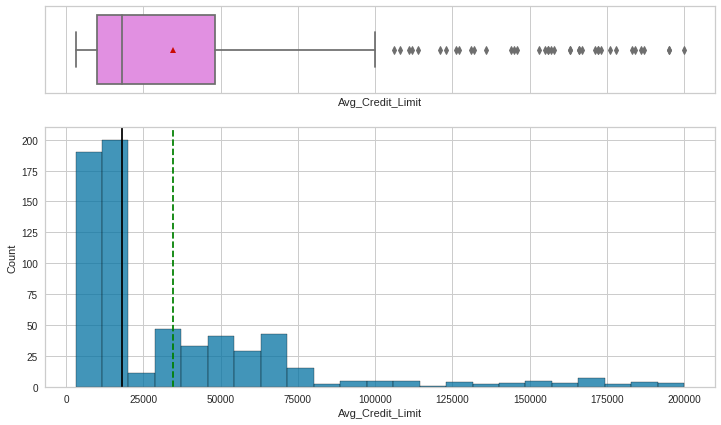

In [14]:
histogram_boxplot(data=df, feature='Avg_Credit_Limit')

**Insights**
- Data has several outliers
- Data is right skewed

**Total_Credit_Cards**

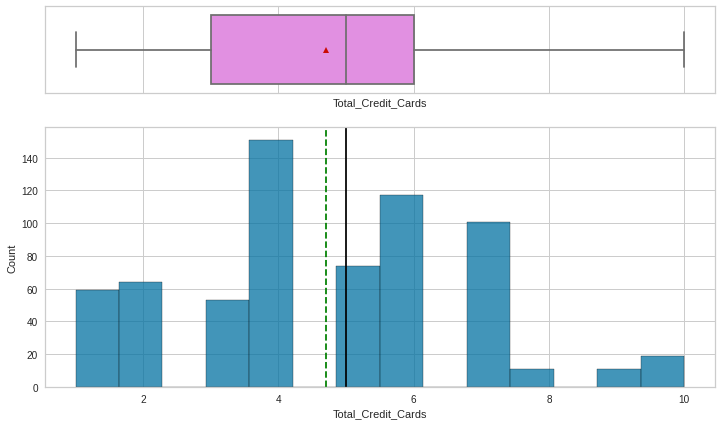

In [15]:
histogram_boxplot(data=df, feature='Total_Credit_Cards')

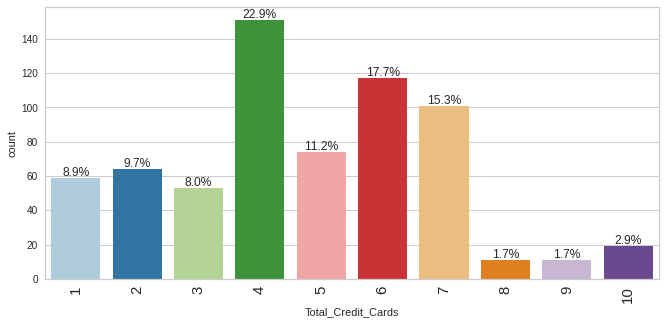

In [16]:
labeled_barplot(data=df, feature='Total_Credit_Cards', perc=True,)

**Insights**
- There are no outliers
- Distribution 'close' to normal

**Total_visits_bank**

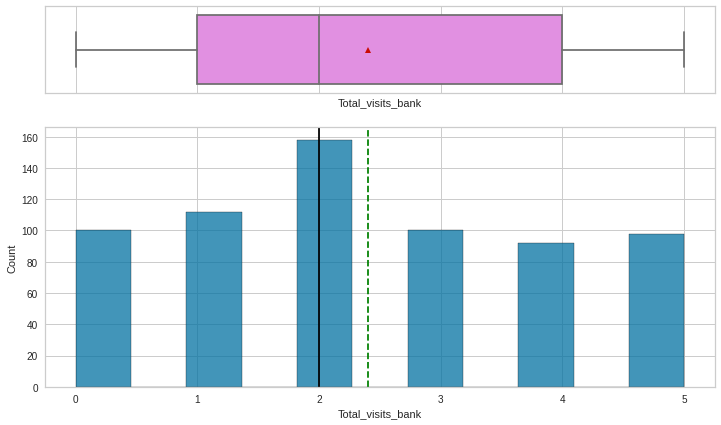

In [17]:
histogram_boxplot(data=df, feature='Total_visits_bank')

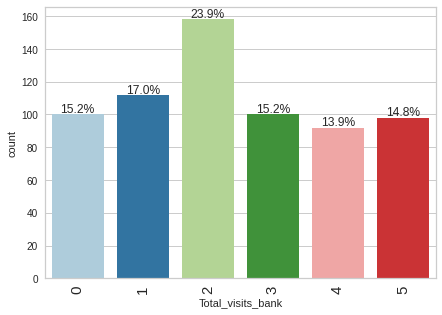

In [18]:
labeled_barplot(data=df, feature='Total_visits_bank', perc=True,)

**Insights**
- The most frequent value is 2 visits per year

**Total_visits_online**

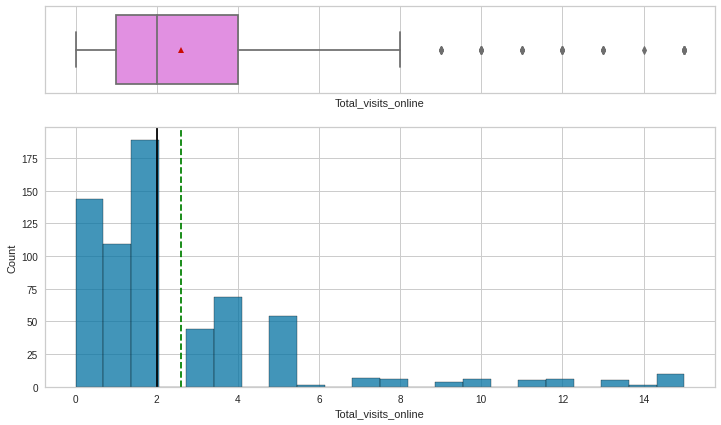

In [19]:
histogram_boxplot(data=df, feature='Total_visits_online')

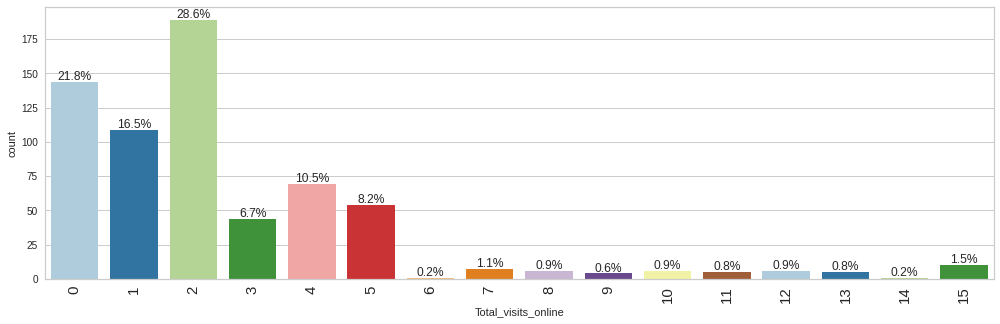

In [20]:
labeled_barplot(data=df, feature='Total_visits_online', perc=True,)

**Insights**
- There are some outliers
- There is right skewness

**Total_calls_made**

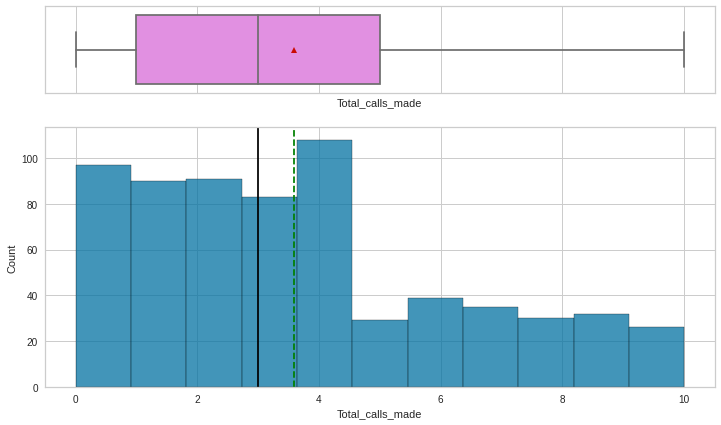

In [21]:
histogram_boxplot(data=df, feature='Total_calls_made')

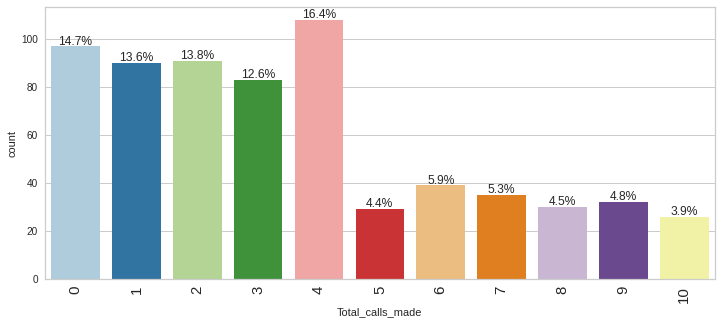

In [22]:
labeled_barplot(data=df, feature='Total_calls_made', perc=True,)

**Insights**
- There is right skewness
- The most frequent value for calls is 4

## Bivariate analysis

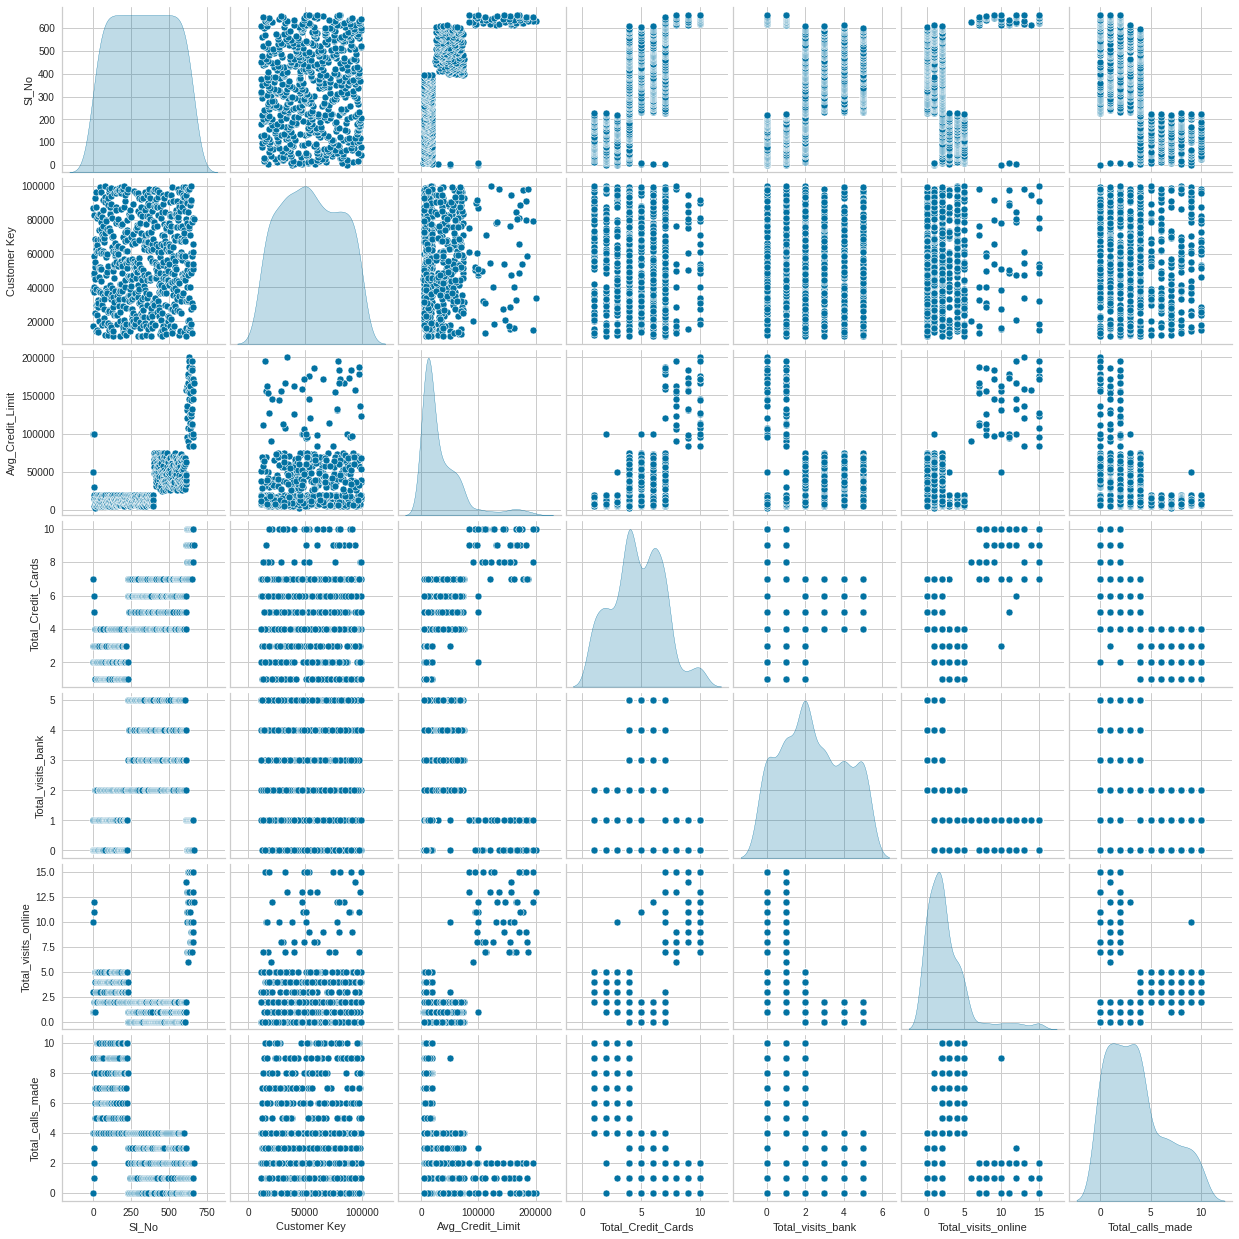

In [23]:
sns.pairplot(data=df, diag_kind='kde')

**Insights**
- There might be some correlation between Avg_Credit_Limit and Total_visits_online, will ecxplore it further later on
- Avg Credit limit has 3 peaks in its distribution
- Total credit cards has 4 peaks in its distribution
- Total visits bank has the largest number of peaks with 6

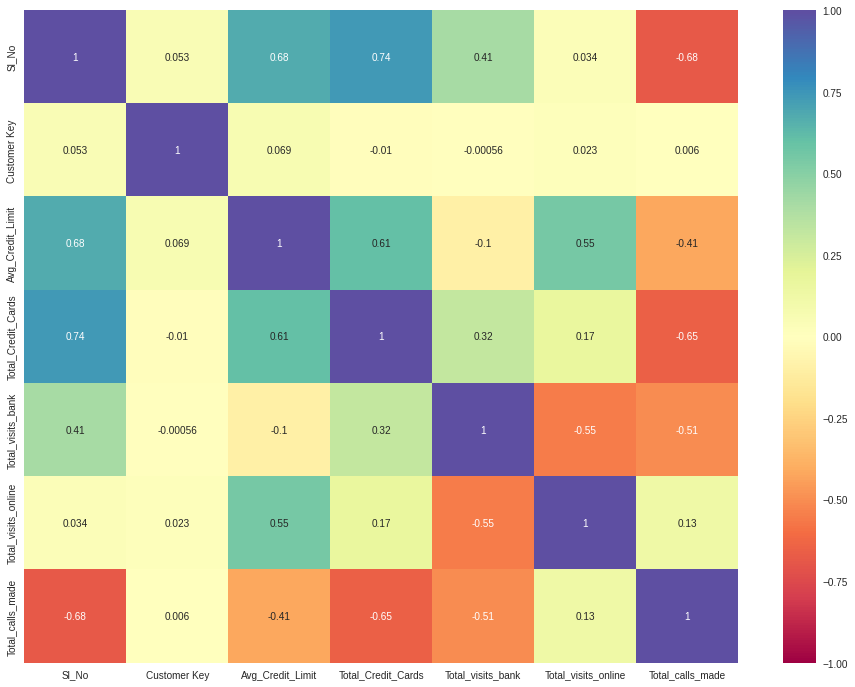

In [24]:
fig = plt.figure(figsize=(16,12))
sns.heatmap(df.corr(), annot=True, cmap='Spectral', vmin=-1, vmax=1)

**Insights**
- There are no significative correleation between features in the data

# Data Preprocesing

In [25]:
# We create a copy of the dataframe
df_p = df.copy()

In [26]:
# we will convert Sl_No to index as it is unique
df_p = df_p.set_index(['Sl_No'])

In [27]:
dupl_CK = df_p[df_p['Customer Key'].duplicated(keep='last')]['Customer Key'].to_list()
df_p[df_p['Customer Key'].isin(dupl_CK)].sort_values(by='Customer Key')

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Sl_No,,,,,,
49,37252,6000,4,0,2,8
433,37252,59000,6,2,1,2
5,47437,100000,6,0,12,3
333,47437,17000,7,3,1,0
412,50706,44000,4,5,0,2
542,50706,60000,7,5,2,2
392,96929,13000,4,5,0,0
399,96929,67000,6,2,2,2
105,97935,17000,2,1,2,10


**Insights**
- The records with duplicated Customer Key have real different data, I will consider an error on the Customer Key and keep the data as it is

In [28]:
# scaling the dataset before clustering
scaler = StandardScaler()
scaled_attr = scaler.fit_transform(df_p.iloc[:,1:])

#creating a dataframe with the scaled atributes
subset_df = pd.DataFrame(scaled_attr, columns=df_p.iloc[:,1:].columns)

In [29]:
subset_df.sample(10)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
305,-0.4142,0.5973,1.5927,-0.5475,0.1455
611,0.3039,1.0590,0.9794,-0.5475,-0.2037
152,-0.5206,-0.7876,-0.2472,-0.2066,0.8441
312,-0.7866,1.0590,0.3661,-0.5475,0.1455
1,0.4103,-0.7876,-1.4737,2.5205,1.8919
280,-0.7334,0.5973,0.9794,-0.5475,-0.5530
646,4.0276,1.0590,-1.4737,1.8387,-0.9023
85,-0.6536,-1.7109,-0.8605,0.4752,0.4948
469,0.8359,0.5973,-0.2472,-0.5475,-0.9023
522,0.0379,1.0590,1.5927,-0.8884,-1.2515


# K-means Clustering

## Elbow Method

Number of Clusters: 1 	Average Distortion: 2.006922226250361
Number of Clusters: 2 	Average Distortion: 1.4571553548514269
Number of Clusters: 3 	Average Distortion: 1.1466276549150365
Number of Clusters: 4 	Average Distortion: 1.0463825294774465
Number of Clusters: 5 	Average Distortion: 0.9908683849620168
Number of Clusters: 6 	Average Distortion: 0.9429479041357717
Number of Clusters: 7 	Average Distortion: 0.9106347837326654
Number of Clusters: 8 	Average Distortion: 0.8924987727303983


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

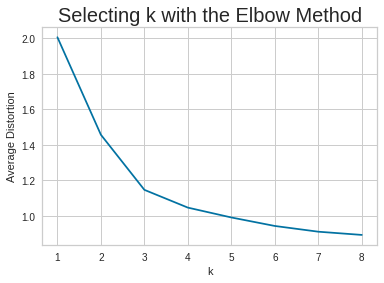

In [30]:
clusters = range(1, 9)
meanDistortions = []  # Create a empty list

for k in clusters:
    model = KMeans(n_clusters=k)  # Initialize KMeans
    model.fit(subset_df)  # Fit kMeans on the data
    prediction = model.predict(subset_df)  # Predict the model on the data
    distortion = (
        sum(np.min(cdist(subset_df, model.cluster_centers_, "euclidean"), axis=1))
        / subset_df.shape[0]  # Find distortion
    )

    meanDistortions.append(
        distortion
    )  # Append distortion values to the empty list created above

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")  # Title of X-axis
plt.ylabel("Average Distortion")  # Title of y-axis
plt.title("Selecting k with the Elbow Method", fontsize=20)  # Title of the plot

**Insights**
- We can see a clear elbow for k=3

## Silhouette score

For n_clusters = 2, silhouette score is 0.41842496663215445
For n_clusters = 3, silhouette score is 0.5157182558881063
For n_clusters = 4, silhouette score is 0.3556670619372605
For n_clusters = 5, silhouette score is 0.2717470361089752
For n_clusters = 6, silhouette score is 0.25545029453623114
For n_clusters = 7, silhouette score is 0.248175083050816
For n_clusters = 8, silhouette score is 0.22577910627822984
For n_clusters = 9, silhouette score is 0.2113000694337469


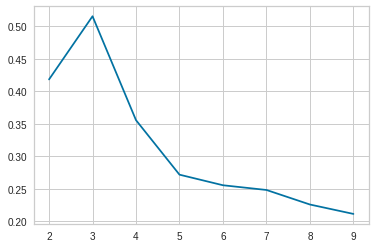

In [31]:
sil_score = []  # Create empty list
cluster_list = list(range(2, 10))  # Creating a list of range from 2 to 10
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)  # Initializing KMeans algorithm
    preds = clusterer.fit_predict((subset_df))  # Predicting on the data
    # centers = clusterer.cluster_centers_
    score = silhouette_score(subset_df, preds)  # Cacalculating silhouette score
    sil_score.append(score)  # Appending silhouette score to empty list created above
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.plot(cluster_list, sil_score)

**Insights** 
- Silhoute score looks good for k=3

## SilhouetteVisualizer

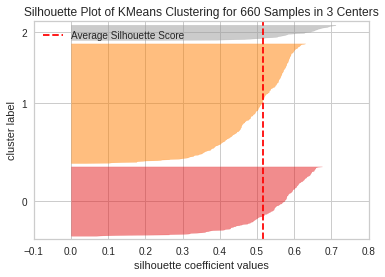

In [32]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(subset_df)
visualizer.show()

**Insights**
- All clusters surpass Avg silhouette score
- All clusters have diferent width sizes
- All clusters have different silhoute scores
- There is an elbow at k=3

So **k=3** is a **GOOD** cluster **size**

## Applying KMeans clustering for 3 centroids (k=3)

In [33]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(subset_df)

KMeans(n_clusters=3, random_state=0)

In [34]:
# adding kmeans cluster labels to the original dataframe
df["K_means_segments"] = kmeans.labels_

In [35]:
df.sample(10)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments
29,30,29112,8000,4,0,4,7,1
239,240,14263,16000,5,2,0,0,0
321,322,11466,9000,7,5,0,0,0
24,25,24001,8000,2,0,2,10,1
263,264,47496,14000,4,2,0,0,0
447,448,81166,61000,5,2,2,1,0
455,456,89446,47000,6,2,0,4,0
424,425,61122,33000,5,4,2,0,0
187,188,38205,16000,2,2,3,8,1
522,523,39285,36000,7,5,0,0,0


## Cluster Profiling

In [36]:
cluster_profile = df.groupby('K_means_segments').mean()
cluster_profile['count_in_each_segment'] = (
    df.groupby('K_means_segments')['Total_Credit_Cards'].count().values
)

In [37]:
# let's display cluster profiles
cluster_profile.iloc[:,2:].style.highlight_max(color='lightgreen').highlight_min(color='lightblue')

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
K_means_segments,,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000,386
1,12174.107143,2.410714,0.933036,3.553571,6.870536,224
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


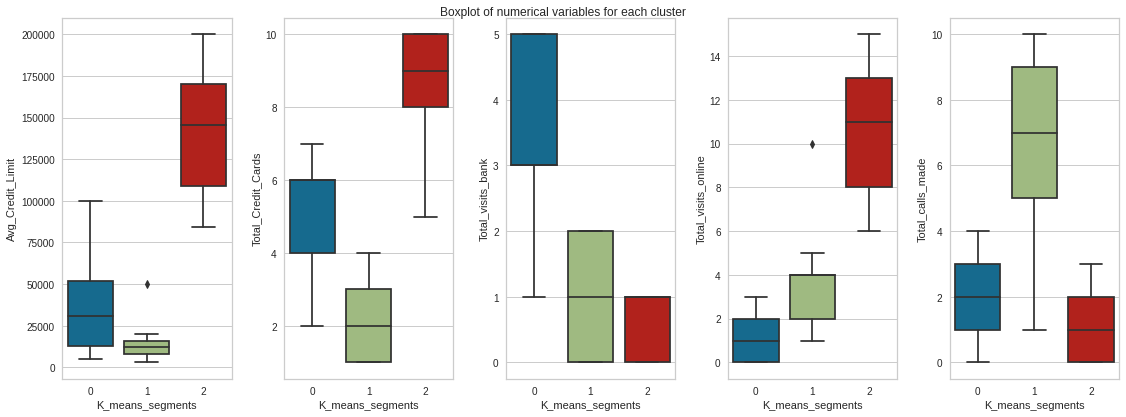

In [38]:
num_col=['Avg_Credit_Limit','Total_Credit_Cards','Total_visits_bank','Total_visits_online','Total_calls_made']

fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=df[num_col[counter]], x=df["K_means_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

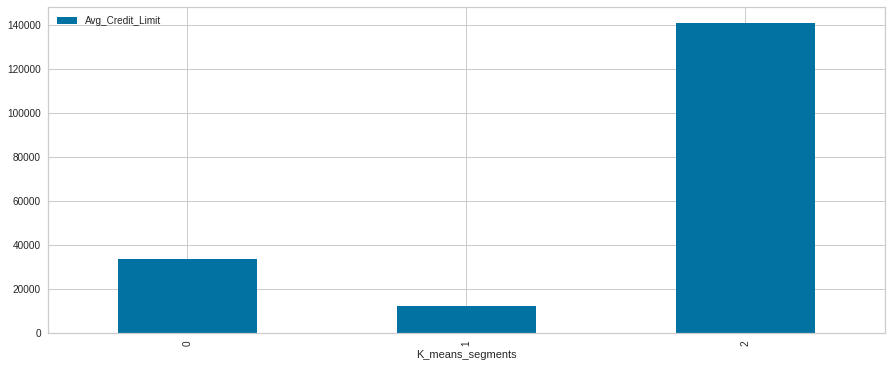

In [39]:
df.groupby("K_means_segments").mean().iloc[:,2:3].plot.bar(figsize=(15, 6))

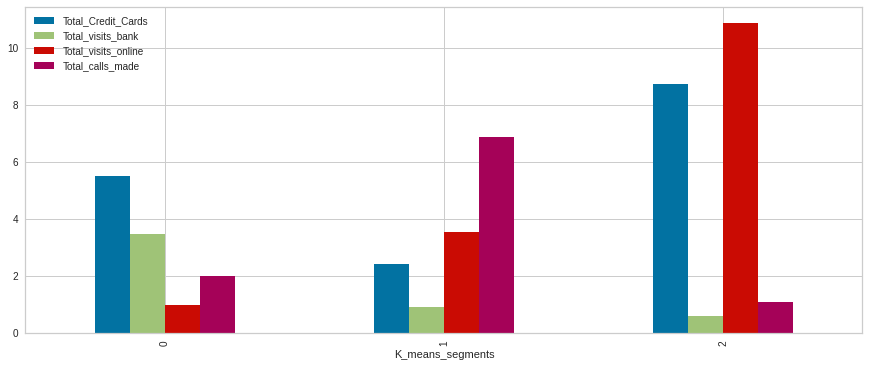

In [40]:
df.groupby("K_means_segments").mean().iloc[:,3:].plot.bar(figsize=(15, 6))

**Insights**
- Cluster 0:
  - Have mid avg credit limit
  - Have mid range of credit cards
  - Vist the bank very often
  - Very few online interaction
  - Mid calls to the bank
- Cluster 1:
  - Have low avg credit limit
  - Have few credit cards
  - Sometimes goes to the bank
  - Mid use of online services
  - Call the bank more frequently
- Cluster 2:
  - Have big avg credit limit
  - Have a lot of credit cards
  - They almost never go to the bank
  - Very intense online clients
  - Almost never calls the bank

# Hierarchical Clustering

## Cophenetic correlation

In [41]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(subset_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.7391220243806552.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8599730607972423.
Cophenetic correlation for Euclidean distance and average linkage is 0.8977080867389372.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8861746814895477.
Cophenetic correlation for Chebyshev distance and single linkage is 0.7382354769296767.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8533474836336782.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8974159511838106.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8913624010768603.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.7058064784553605.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.6663534463875359.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.8326994115042136.
Cophenetic co

In [42]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8977080867389372, which is obtained with Euclidean distance and average linkage.


**Let's explore different linkage methods with Euclidean distance only.**

In [43]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(subset_df, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(subset_df))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.7391220243806552.
Cophenetic correlation for complete linkage is 0.8599730607972423.
Cophenetic correlation for average linkage is 0.8977080867389372.
Cophenetic correlation for centroid linkage is 0.8939385846326323.
Cophenetic correlation for ward linkage is 0.7415156284827493.
Cophenetic correlation for weighted linkage is 0.8861746814895477.


In [44]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8977080867389372, which is obtained with average linkage.


**We see that the cophenetic correlation is maximum with Euclidean distance and average linkage.**

**Let's see the dendrograms for the different linkage methods.**

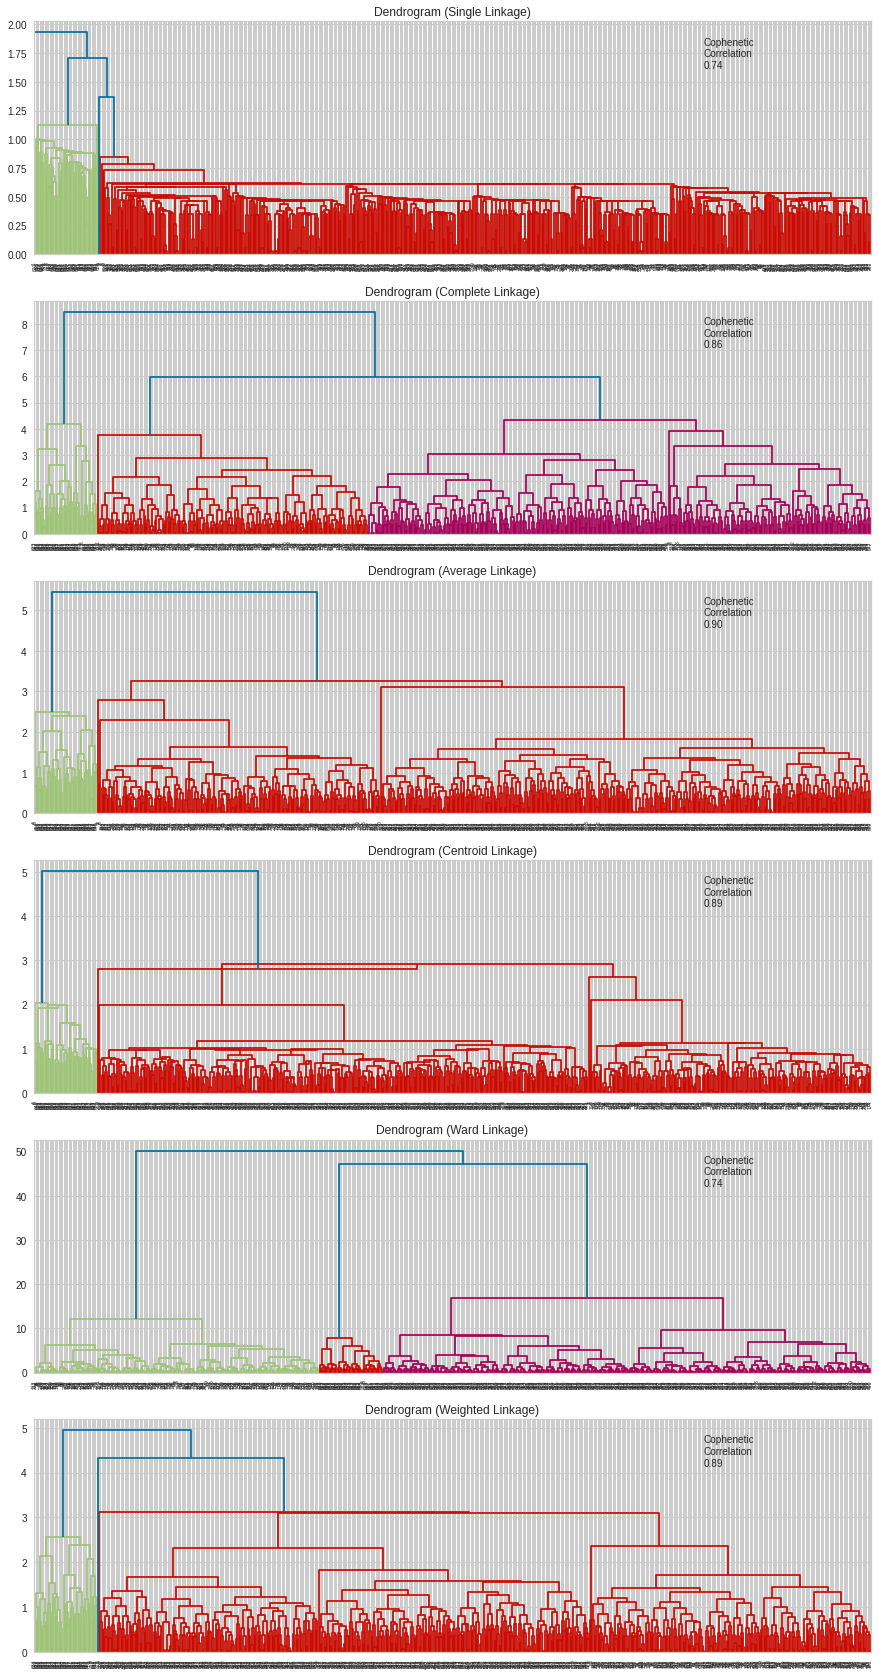

In [45]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

**insights**
- Average linkage has the highest Cophenetic correelation
- 3 appears to be the appropriate number of clusters from the dendrogram for Centroid linkage

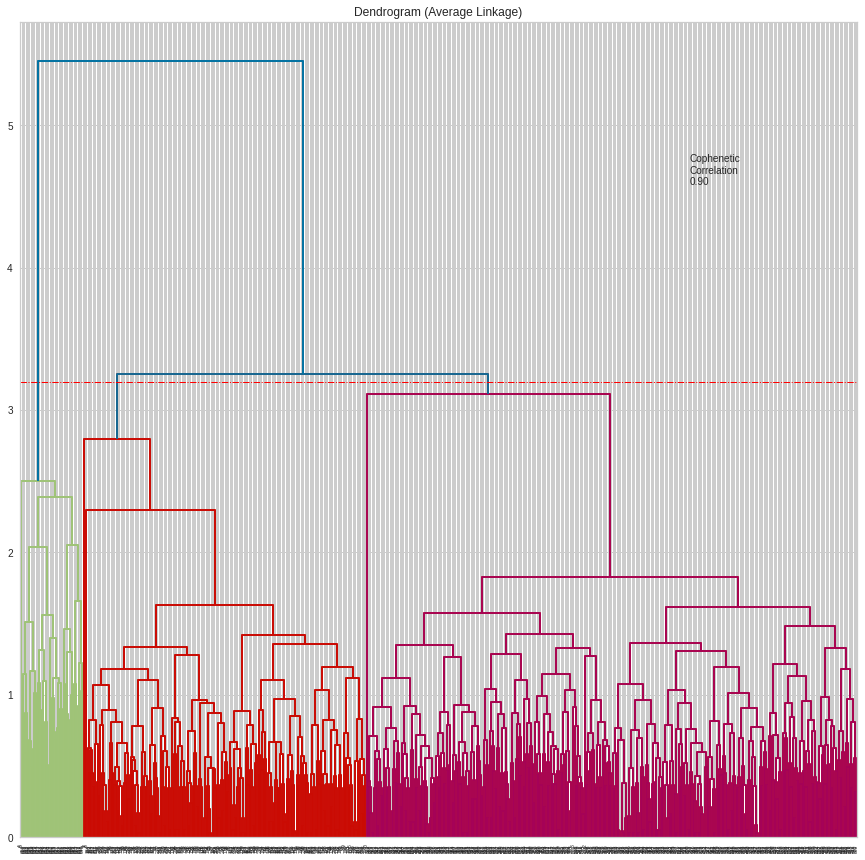

In [46]:
# list of linkage methods
linkage_methods = ["average"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 15))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs)
    axs.set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_df))
    axs.annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )
dendrogram(Z, color_threshold=3.2)
plt.axhline(y=3.2, c="red", lw=1, linestyle="dashdot")

## Build hierarchical clustering

In [47]:
HCmodel = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="average")
HCmodel.fit(subset_df)

AgglomerativeClustering(linkage='average', n_clusters=3)

In [48]:
# adding HC cluster labels to the original dataframe
df["HC_Clusters"] = HCmodel.labels_

## Cluster Profiling

In [49]:
cluster_profile_hc = df.groupby("HC_Clusters").mean()

In [50]:
cluster_profile_hc["count_in_each_segments"] = (
    df.groupby("HC_Clusters")["Avg_Credit_Limit"].count().values
)

In [51]:
cluster_profile_hc.iloc[:,2:].style.highlight_max(color='lightgreen').highlight_min(color='lightblue')

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments,count_in_each_segments
HC_Clusters,,,,,,,
0,33713.178295,5.511628,3.485788,0.984496,2.005168,0.002584,387
1,141040.000000,8.740000,0.600000,10.900000,1.080000,2.000000,50
2,12197.309417,2.403587,0.928251,3.560538,6.883408,1.000000,223


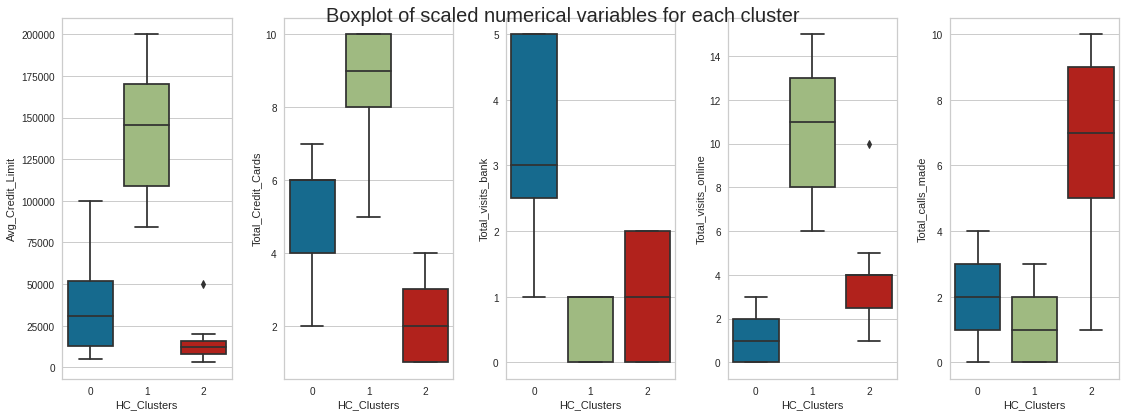

In [52]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of scaled numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=df[num_col[counter]], x=df["HC_Clusters"])
    counter = counter + 1

fig.tight_layout(pad=2.0)


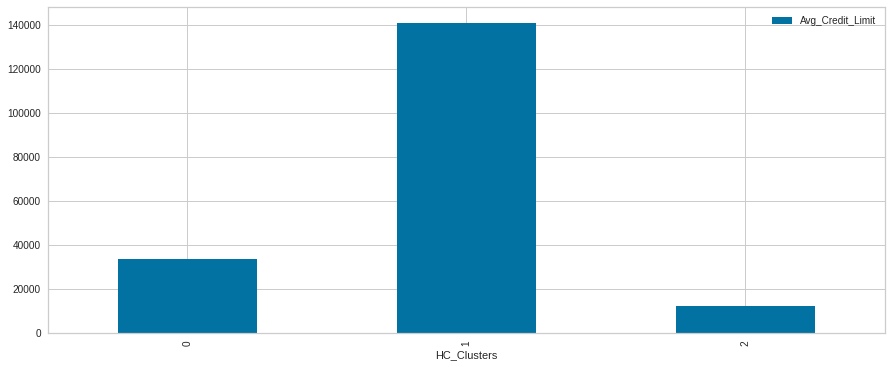

In [53]:
df.groupby("HC_Clusters").mean().iloc[:,2:3].plot.bar(figsize=(15, 6))

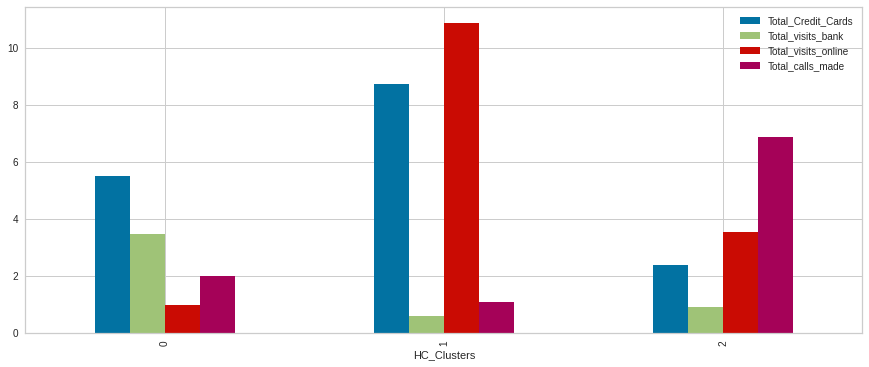

In [54]:
df.groupby("HC_Clusters").mean().iloc[:,3:-1].plot.bar(figsize=(15, 6))

**Insights**
- Cluster 0:
  - Have mid avg credit limit
  - Have mid range of credit cards
  - Vist the bank very often
  - Very few online interaction
  - Mid calls to the bank
- Cluster 1:
  - Have big avg credit limit
  - Have a lot of credit cards
  - They almost never go to the bank
  - Very intense online clients
  - Almost never calls the bank
- Cluster 2:
  - Have low avg credit limit
  - Have few credit cards
  - Sometimes goes to the bank
  - Mid use of online services
  - Call the bank more frequently


# Compare clusters from K-mean vs Hierarchical Clustering

In [55]:
df.K_means_segments.value_counts()

0    386
1    224
2     50
Name: K_means_segments, dtype: int64

In [56]:
df.HC_Clusters.value_counts()

0    387
2    223
1     50
Name: HC_Clusters, dtype: int64



|K-mean Cluster 0|Hierarchical Cluster 0|
|---|---|
|  - Have mid avg credit limit|- Have mid avg credit limit|
|  - Have mid range of credit cards|- Have mid range of credit cards|
|  - Vist the bank very often|- Vist the bank very often|
|  - Very few online interaction|- Very few online interaction|
|  - Mid calls to the bank|- Mid calls to the bank|



|K-mean Cluster 1|Hierarchical Cluster 2|
|---|---|
|  - Have low avg credit limit|- Have low avg credit limit|
|  - Have few credit cards|- Have few credit cards|
|  - Sometimes goes to the bank|  - Sometimes goes to the bank|
|  - Mid use of online services|  - Mid use of online services|
|  - Call the bank more frequently|  - Call the bank more frequently|


|K-mean Cluster 2|Hierarchical Cluster 1|
|---|---|
|  - Have big avg credit limit|  - Have big avg credit limit|
|  - Have a lot of credit cards|  - Have a lot of credit cards|
|  - They almost never go to the bank|  - They almost never go to the bank|
|  - Very intense online clients|  - Very intense online clients|
|  - Almost never calls the bank|  - Almost never calls the bank|

As we can see both methods gave as a result the same clusters.

The number of records in every class is practically the same also.

# Actionable Insights & Recommendations

We can make the following **client segmentation** of AllLife Bank customers:

- The first cluster is formed by clients who have a mid average credit limit, who visit the bank ogten, have a mid range of credit cards, almost do not use the online banking and make calls to the bank now and then.
- The second cluster is formed by customers with very little average credit limit, who have very few credit cards, sometimes visit the bank or use the online services and prefer to call the bank
- The third cluster is formed of customers with a big average credit limit who owns a big variety of credit cards and prefer the online banking vs visit or call the bank

With this knowledge we can advise several areas of the bank to produce improvements:
- Our **credit team** should prepare **different credit card options** for **every cluster** with differences in credit card characteristics such as rate, commision, default interesst rate
- Our **external affairs team** should do **strategic alliances** with prime retailers, outfits, sports teams, restaurant chains, etc. in order to boost the customer experience in every cluster
- Our **marketing team** should prepare **marketing campaigns** accordingly in order to grow attract customers and boost the net profit

# Convert ipynb to HTML

In [57]:
%%shell
jupyter nbconvert --to html ///content/Project_6_Unsupervised_Learning_AllLife_Bank_Customer_Segmentation_EMS.ipynb

[NbConvertApp] Converting notebook ///content/Project_6_Unsupervised_Learning_AllLife_Bank_Customer_Segmentation_EMS.ipynb to html
[NbConvertApp] Writing 1671920 bytes to ///content/Project_6_Unsupervised_Learning_AllLife_Bank_Customer_Segmentation_EMS.html
